In [1]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import RESULTS_DIR
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import MOOD_BASELINES
from mood.utils import get_outlier_bounds
from mood.metrics import Metric

/home/adamizdebski/miniconda3/envs/mood-experiments/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MOOD_REPRESENTATIONS = ["MolGPT", "UniMol", "Moler", "RegressionTransformer", "Jointformer"]

In [3]:
in_dir = 'results'
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [4]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, MOOD_BASELINES, MOOD_REPRESENTATIONS))
# assert len(list(all_triplets)) == len(paths), find_missing(paths, all_triplets)

In [5]:
df_original = pd.concat(dm.utils.parallelized(pd.read_csv, paths, progress=True), ignore_index=True)

100%|██████████| 161/161 [00:01<00:00, 153.35it/s]


In [6]:
df_original

,dataset,algorithm,representation,iid_score,ood_score,metric,type
0,BBB,GP,Jointformer,0.757462,0.755211,AUROC,performance
1,BBB,GP,Jointformer,0.161261,0.161477,Brier score,calibration
2,BBB,GP,MolGPT,0.760392,0.739342,AUROC,performance
3,BBB,GP,MolGPT,0.128499,0.129723,Brier score,calibration
4,BBB,GP,Moler,0.783056,0.784455,AUROC,performance
...,...,...,...,...,...,...,...
317,hERG,RF,Moler,0.204635,0.212360,Brier score,calibration
318,hERG,RF,RegressionTransformer,0.519369,0.521717,AUROC,performance
319,hERG,RF,RegressionTransformer,0.208419,0.207662,Brier score,calibration
320,hERG,RF,UniMol,0.718531,0.720007,AUROC,performance


In [7]:
# Some models learn to predict a constant function. This results in a NaN pearson score.
# We replace this by zeroes to still include them in our analysis
mask = pd.isna(df_original).any(axis=1) & (df_original["metric"] == "Pearson")
df_original.loc[mask, "score_mu"] = 0
df_original.loc[mask, "score_std"] = 0

In [8]:
df_original.groupby(["type", "metric"])[["iid_score", "ood_score"]].describe()

iid_score                                            \
                            count       mean        std       min       25%   
type        metric                                                            
calibration Brier score      87.0   0.233741   0.122409  0.000000  0.146880   
            Pearson          74.0   0.162826   0.169400 -0.097971  0.028208   
performance AUROC            87.0   0.729009   0.146588  0.000000  0.716865   
            MAE              74.0  14.218566  14.141464  0.337727  0.650777   

                                                         ood_score             \
                               50%        75%        max     count       mean   
type        metric                                                              
calibration Brier score   0.208419   0.305943   0.555570      87.0   0.241767   
            Pearson       0.132102   0.258829   0.856150      74.0   0.146335   
performance AUROC         0.757462   0.804457   0.891254      87.0   0.717384   
            MAE          10.214765  22.969606  42.247257      74.0  14.381037   

                                                                              \
                               std       min       25%        50%        75%   
type        metric                                                             
calibration Brier score   0.126928  0.000000  0.155639   0.212360   0.311278   
            Pearson       0.165643 -0.097846  0.023998   0.108145   0.243930   
performance AUROC         0.142138  0.000000  0.699158   0.749713   0.786795   
            MAE          14.328346  0.350131  0.688399  10.583314  23.886473   

                                    
                               max  
type        metric                  
calibration Brier score   0.537176  
            Pearson       0.856906  
performance AUROC         0.876977  
            MAE          42.162037

In [9]:
df = df_original.copy()
df = df[df["type"] == "performance"]
df = df[df["metric"] == "AUROC"]
df.groupby("representation")["ood_score"].agg(["mean", "std"])

,mean,std
representation,,
Jointformer,0.748654,0.189827
MolGPT,0.758111,0.050967
Moler,0.747285,0.050270
RegressionTransformer,0.600145,0.096708
UniMol,0.730134,0.187189


In [10]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# Upscale the Pearson correlation to go from [-1, 1] to [0, 1]
df.loc[df["metric"] == "Pearson", "iid_score"] = (df["iid_score"] + 1) / 2
df.loc[df["metric"] == "Pearson", "ood_score"] = (df["ood_score"] + 1) / 2

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

# Invert the gap of metrics that need to be minimized, so that a high gap is always better
df["metric_direction"] = df["metric"].apply(lambda x: Metric.by_name(x).mode)
df.loc[df["gap"] == "min", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "min", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,score_mu,score_std,gap,relative_gap,metric_direction
0,BBB,GP,Jointformer,0.757462,0.755211,AUROC,performance,NaN,NaN,-0.002251,-0.297212,max
1,BBB,GP,Jointformer,0.161261,0.161477,Brier score,calibration,NaN,NaN,0.000216,-0.133653,min
2,BBB,GP,MolGPT,0.760392,0.739342,AUROC,performance,NaN,NaN,-0.021050,-2.768352,max
3,BBB,GP,MolGPT,0.128499,0.129723,Brier score,calibration,NaN,NaN,0.001225,-0.952977,min
4,BBB,GP,Moler,0.783056,0.784455,AUROC,performance,NaN,NaN,0.001399,0.178710,max


In [11]:
df[df['metric'] == 'MAE']

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,score_mu,score_std,gap,relative_gap,metric_direction
54,Caco-2,GP,Jointformer,0.353022,0.367879,MAE,performance,NaN,NaN,0.014857,-4.208395,min
56,Caco-2,GP,MolGPT,0.380055,0.417331,MAE,performance,NaN,NaN,0.037276,-9.808057,min
58,Caco-2,GP,Moler,0.369924,0.389503,MAE,performance,NaN,NaN,0.019580,-5.292872,min
60,Caco-2,GP,RegressionTransformer,0.527705,0.528526,MAE,performance,NaN,NaN,0.000821,-0.155522,min
62,Caco-2,GP,UniMol,0.398145,0.410313,MAE,performance,NaN,NaN,0.012168,-3.056247,min
...,...,...,...,...,...,...,...,...,...,...,...,...
252,PPBR,RF,Jointformer,9.332050,10.123286,MAE,performance,NaN,NaN,0.791236,-8.478693,min
254,PPBR,RF,MolGPT,9.441742,10.520312,MAE,performance,NaN,NaN,1.078570,-11.423426,min
256,PPBR,RF,Moler,10.619419,11.230550,MAE,performance,NaN,NaN,0.611131,-5.754841,min
258,PPBR,RF,RegressionTransformer,11.841567,11.846926,MAE,performance,NaN,NaN,0.005359,-0.045253,min


In [12]:
metric = 'MAE'
df_performance = df.copy()
df_performance = df_performance[df_performance['metric'] == metric]
df_performance['Representation'] = pd.Categorical(df_performance['Representation'], MOOD_REPRESENTATIONS)
df_performance.sort_values(by=['algorithm', 'Representation'])
df_performance.drop(['type', 'score_mu', 'score_std', 'gap', 'metric_direction', 'metric'], axis=1, inplace=True)
df_performance.iid_score = df_performance.iid_score.round(3)
df_performance.ood_score = df_performance.ood_score.round(3)
columns = ['Dataset', 'algorithm', 'Representation', 'iid_score', 'ood_score', 'metric']
print(df_performance.to_latex(
    index=False,
    formatters={"algorithm": str.upper},
    float_format="{:.3f}".format
    ))


\begin{tabular}{lllrrr}
\toprule
Dataset & algorithm & Representation & iid_score & ood_score & relative_gap \\
\midrule
Caco-2 & GP & Jointformer & 0.353 & 0.368 & -4.208 \\
Caco-2 & GP & MolGPT & 0.380 & 0.417 & -9.808 \\
Caco-2 & GP & Moler & 0.370 & 0.390 & -5.293 \\
Caco-2 & GP & RegressionTransformer & 0.528 & 0.529 & -0.156 \\
Caco-2 & GP & UniMol & 0.398 & 0.410 & -3.056 \\
Caco-2 & MLP & Jointformer & 0.338 & 0.350 & -3.673 \\
Caco-2 & MLP & MolGPT & 0.358 & 0.393 & -9.893 \\
Caco-2 & MLP & Moler & 0.351 & 0.370 & -5.336 \\
Caco-2 & MLP & RegressionTransformer & 0.532 & 0.533 & -0.180 \\
Caco-2 & MLP & UniMol & 0.389 & 0.397 & -1.968 \\
Caco-2 & RF & Jointformer & 0.369 & 0.386 & -4.467 \\
Caco-2 & RF & MolGPT & 0.391 & 0.428 & -9.635 \\
Caco-2 & RF & Moler & 0.408 & 0.442 & -8.299 \\
Caco-2 & RF & RegressionTransformer & 0.536 & 0.536 & 0.038 \\
Caco-2 & RF & UniMol & 0.458 & 0.480 & -4.913 \\
Clearance & GP & Jointformer & 35.104 & 36.023 & -2.619 \\
Clearance & GP & MolGPT 

In [13]:
metric = 'AUROC'
df_performance = df.copy()
df_performance = df_performance[df_performance['metric'] == metric]
df_performance['Representation'] = pd.Categorical(df_performance['Representation'], MOOD_REPRESENTATIONS)
df_performance.sort_values(by=['algorithm', 'Representation'])
df_performance.drop(['type', 'score_mu', 'score_std', 'gap', 'metric_direction', 'metric'], axis=1, inplace=True)
df_performance.iid_score = df_performance.iid_score.round(3)
df_performance.ood_score = df_performance.ood_score.round(3)
columns = ['Dataset', 'algorithm', 'Representation', 'iid_score', 'ood_score', 'metric']
print(df_performance.to_latex(
    index=False,
    formatters={"algorithm": str.upper},
    float_format="{:.3f}".format
    ))


\begin{tabular}{lllrrr}
\toprule
Dataset & algorithm & Representation & iid_score & ood_score & relative_gap \\
\midrule
BBB & GP & Jointformer & 0.757 & 0.755 & -0.297 \\
BBB & GP & MolGPT & 0.760 & 0.739 & -2.768 \\
BBB & GP & Moler & 0.783 & 0.784 & 0.179 \\
BBB & GP & RegressionTransformer & 0.666 & 0.665 & -0.146 \\
BBB & GP & UniMol & 0.749 & 0.749 & -0.066 \\
BBB & MLP & Jointformer & 0.794 & 0.797 & 0.389 \\
BBB & MLP & MolGPT & 0.793 & 0.765 & -3.574 \\
BBB & MLP & Moler & 0.797 & 0.787 & -1.220 \\
BBB & MLP & RegressionTransformer & 0.665 & 0.664 & -0.197 \\
BBB & MLP & UniMol & 0.753 & 0.750 & -0.484 \\
BBB & RF & Jointformer & 0.767 & 0.770 & 0.369 \\
BBB & RF & MolGPT & 0.745 & 0.718 & -3.583 \\
BBB & RF & Moler & 0.752 & 0.731 & -2.745 \\
BBB & RF & RegressionTransformer & 0.696 & 0.696 & -0.008 \\
BBB & RF & UniMol & 0.749 & 0.747 & -0.246 \\
CYP2C9 & MLP & Jointformer & 0.000 & 0.000 & NaN \\
CYP2C9 & MLP & UniMol & 0.000 & 0.000 & NaN \\
CYP2C9 & MLP & Jointformer & 0.

In [14]:
metric = 'Brier score'
df_performance = df.copy()
df_performance = df_performance[df_performance['metric'] == metric]
df_performance['Representation'] = pd.Categorical(df_performance['Representation'], MOOD_REPRESENTATIONS)
df_performance.sort_values(by=['algorithm', 'Representation'])
df_performance.drop(['type', 'score_mu', 'score_std', 'gap', 'metric_direction', 'metric'], axis=1, inplace=True)
df_performance.iid_score = df_performance.iid_score.round(3)
df_performance.ood_score = df_performance.ood_score.round(3)
columns = ['Dataset', 'algorithm', 'Representation', 'iid_score', 'ood_score', 'metric']
print(df_performance.to_latex(
    index=False,
    formatters={"algorithm": str.upper},
    float_format="{:.3f}".format
    ))


\begin{tabular}{lllrrr}
\toprule
Dataset & algorithm & Representation & iid_score & ood_score & relative_gap \\
\midrule
BBB & GP & Jointformer & 0.161 & 0.161 & -0.134 \\
BBB & GP & MolGPT & 0.128 & 0.130 & -0.953 \\
BBB & GP & Moler & 0.156 & 0.196 & -25.317 \\
BBB & GP & RegressionTransformer & 0.091 & 0.090 & 1.194 \\
BBB & GP & UniMol & 0.139 & 0.156 & -12.247 \\
BBB & MLP & Jointformer & 0.168 & 0.173 & -2.858 \\
BBB & MLP & MolGPT & 0.150 & 0.146 & 3.140 \\
BBB & MLP & Moler & 0.168 & 0.189 & -12.614 \\
BBB & MLP & RegressionTransformer & 0.088 & 0.086 & 1.736 \\
BBB & MLP & UniMol & 0.134 & 0.155 & -15.447 \\
BBB & RF & Jointformer & 0.154 & 0.158 & -2.486 \\
BBB & RF & MolGPT & 0.150 & 0.152 & -1.420 \\
BBB & RF & Moler & 0.177 & 0.193 & -9.132 \\
BBB & RF & RegressionTransformer & 0.200 & 0.198 & 0.817 \\
BBB & RF & UniMol & 0.178 & 0.196 & -10.661 \\
CYP2C9 & MLP & Jointformer & 0.000 & 0.000 & NaN \\
CYP2C9 & MLP & UniMol & 0.000 & 0.000 & NaN \\
CYP2C9 & MLP & Jointformer 

In [15]:
metric = 'Pearson'
df_performance = df.copy()
df_performance = df_performance[df_performance['metric'] == metric]
df_performance['Representation'] = pd.Categorical(df_performance['Representation'], MOOD_REPRESENTATIONS)
df_performance.sort_values(by=['algorithm', 'Representation'])
df_performance.drop(['type', 'score_mu', 'score_std', 'gap', 'metric_direction', 'metric'], axis=1, inplace=True)
df_performance.iid_score = df_performance.iid_score.round(3)
df_performance.ood_score = df_performance.ood_score.round(3)
columns = ['Dataset', 'algorithm', 'Representation', 'iid_score', 'ood_score', 'metric']
print(df_performance.to_latex(
    index=False,
    formatters={"algorithm": str.upper},
    float_format="{:.3f}".format
    ))


\begin{tabular}{lllrrr}
\toprule
Dataset & algorithm & Representation & iid_score & ood_score & relative_gap \\
\midrule
Caco-2 & GP & Jointformer & 0.507 & 0.500 & -1.363 \\
Caco-2 & GP & MolGPT & 0.642 & 0.598 & -6.758 \\
Caco-2 & GP & Moler & 0.487 & 0.480 & -1.417 \\
Caco-2 & GP & RegressionTransformer & 0.532 & 0.515 & -3.342 \\
Caco-2 & GP & UniMol & 0.521 & 0.518 & -0.638 \\
Caco-2 & MLP & Jointformer & 0.559 & 0.547 & -2.023 \\
Caco-2 & MLP & MolGPT & 0.631 & 0.594 & -5.783 \\
Caco-2 & MLP & Moler & 0.532 & 0.533 & 0.100 \\
Caco-2 & MLP & RegressionTransformer & 0.515 & 0.512 & -0.699 \\
Caco-2 & MLP & UniMol & 0.513 & 0.521 & 1.411 \\
Caco-2 & RF & Jointformer & 0.673 & 0.634 & -5.714 \\
Caco-2 & RF & MolGPT & 0.675 & 0.649 & -3.870 \\
Caco-2 & RF & Moler & 0.689 & 0.672 & -2.348 \\
Caco-2 & RF & RegressionTransformer & 0.626 & 0.622 & -0.572 \\
Caco-2 & RF & UniMol & 0.687 & 0.690 & 0.438 \\
Clearance & GP & Jointformer & 0.480 & 0.471 & -1.748 \\
Clearance & GP & MolGPT & 0.

In [34]:
print(df_calibration[df_calibration['metric'] == 'Brier score'].to_latex(
    index=False,
    formatters={"algorithm": str.upper},
    float_format="{:.3f}".format))

\begin{tabular}{lllrrl}
\toprule
Dataset & algorithm & Representation & iid_score & ood_score & metric \\
\midrule
BBB & GP & Jointformer & 0.161 & 0.161 & Brier score \\
BBB & GP & UniMol & 0.139 & 0.156 & Brier score \\
BBB & MLP & Jointformer & 0.168 & 0.173 & Brier score \\
BBB & MLP & UniMol & 0.134 & 0.155 & Brier score \\
BBB & RF & Jointformer & 0.154 & 0.158 & Brier score \\
BBB & RF & UniMol & 0.178 & 0.196 & Brier score \\
CYP2C9 & MLP & Jointformer & 0.000 & 0.000 & Brier score \\
CYP2C9 & MLP & UniMol & 0.000 & 0.000 & Brier score \\
CYP2C9 & MLP & Jointformer & 0.534 & 0.537 & Brier score \\
CYP2C9 & MLP & UniMol & 0.526 & 0.499 & Brier score \\
CYP2C9 & RF & Jointformer & 0.406 & 0.413 & Brier score \\
CYP2C9 & RF & UniMol & 0.357 & 0.339 & Brier score \\
DILI & GP & Jointformer & 0.292 & 0.282 & Brier score \\
DILI & GP & UniMol & 0.263 & 0.248 & Brier score \\
DILI & MLP & Jointformer & 0.363 & 0.340 & Brier score \\
DILI & MLP & UniMol & 0.360 & 0.320 & Brier score \\

In [39]:
print(df_calibration[df_calibration['metric'] != 'Brier score'].to_latex(
    index=False,
    formatters={"algorithm": str.upper},
    float_format="{:.3f}".format))

\begin{tabular}{lllrrl}
\toprule
Dataset & algorithm & Representation & iid_score & ood_score & metric \\
\midrule
Caco-2 & GP & Jointformer & 0.507 & 0.500 & Pearson \\
Caco-2 & GP & UniMol & 0.521 & 0.518 & Pearson \\
Caco-2 & MLP & Jointformer & 0.559 & 0.547 & Pearson \\
Caco-2 & MLP & UniMol & 0.513 & 0.521 & Pearson \\
Caco-2 & RF & Jointformer & 0.673 & 0.634 & Pearson \\
Caco-2 & RF & UniMol & 0.687 & 0.690 & Pearson \\
Clearance & GP & Jointformer & 0.480 & 0.471 & Pearson \\
Clearance & GP & UniMol & 0.494 & 0.501 & Pearson \\
Clearance & MLP & Jointformer & 0.559 & 0.554 & Pearson \\
Clearance & MLP & UniMol & 0.535 & 0.533 & Pearson \\
Clearance & RF & Jointformer & 0.684 & 0.670 & Pearson \\
Clearance & RF & UniMol & 0.624 & 0.600 & Pearson \\
HalfLife & GP & Jointformer & 0.531 & 0.532 & Pearson \\
HalfLife & GP & UniMol & 0.535 & 0.532 & Pearson \\
HalfLife & MLP & Jointformer & 0.606 & 0.606 & Pearson \\
HalfLife & MLP & UniMol & 0.571 & 0.574 & Pearson \\
HalfLife & RF

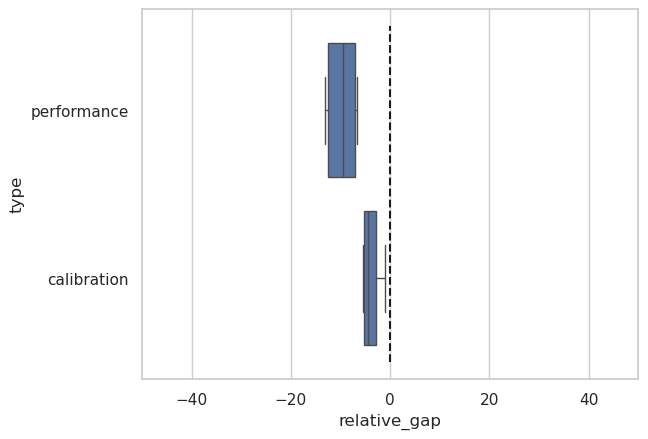

In [53]:
ax = sns.boxplot(data=df, x="relative_gap", y="type")
ax.set_xlim([-50, 50])
ax.plot([0, 0], ax.get_ylim(), "k--")

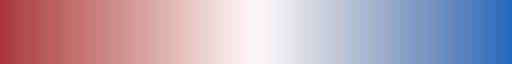

In [54]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
cmap

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

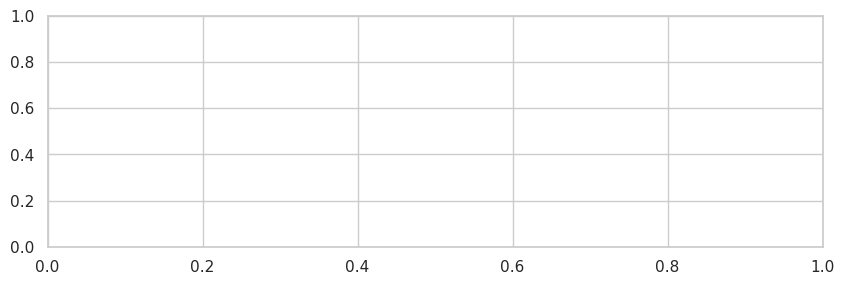

In [55]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        pivot = pivot.reindex(MOOD_REPRESENTATIONS)
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(f"{name} - {metric_type.capitalize()}")
        ax.text(
            0.85, 
            0.5, 
            f"{'OOD better':25} OOD worse", 
            rotation=-90, 
            ha="center", 
            va="center", 
            transform=fig.transFigure
        )

# Condensed
This is meant to condense the information in a smaller, easier to read plot suited for publications

In [19]:
c1 = df.groupby(["Dataset", "Representation", "metric", "type", "metric_direction"]).std()["relative_gap"]
c2 = df.groupby(["Dataset", "Representation", "metric", "type", "metric_direction"]).mean()["relative_gap"]
data = pd.DataFrame({"std": c1, "mean": c2}).reset_index()
data.head()

ValueError: could not convert string to float: 'GP'

In [20]:
data[data["Dataset"] == "Lipophilicity"]

NameError: name 'data' is not defined

In [21]:
sns.set(style="whitegrid")

scale_vmax = data["std"].max()

lower, upper = get_outlier_bounds(data["mean"].to_numpy())
hue_vmin = min(lower, -upper)
hue_vmax = -hue_vmin

for metric_type, metric_group in data.groupby("type"):
    
    metric_group = metric_group.sort_values(
        by=["Dataset", "Representation"], 
        key=lambda x: [MOOD_DATASETS.index(x_) if x_ in MOOD_DATASETS else len(MOOD_REPRESENTATIONS) - MOOD_REPRESENTATIONS.index(x_) for x_ in x]
    )

    g = sns.relplot(
        x="Dataset", 
        y="Representation",
        hue="mean", 
        size="std",
        hue_norm=(hue_vmin, hue_vmax), 
        size_norm=(0, scale_vmax),
        palette="vlag_r", 
        sizes=(3000, 100),
        marker="s", 
        linewidth=0, 
        legend=False, 
        aspect=2, 
        height=6.5, 
        data=metric_group,
    )
    g.ax.invert_yaxis()
    ghost = g.ax.scatter([], [], c=[], vmin=hue_vmin, vmax=hue_vmax, cmap="vlag_r")
    cbar = g.fig.colorbar(ghost)
    cbar.ax.set_yticklabels([f"{label.get_text()}%" for label in cbar.ax.get_yticklabels()])
    
    g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=30, ha="center")
    g.ax.set_title(metric_type.capitalize(), fontweight="bold", y=1.05)
    g.ax.text(
        .93, 
        0.9, 
        f"Better OOD {metric_type}", 
        rotation=-90, 
        ha="center", 
        va="top", 
        transform=g.fig.transFigure
    )
    
    g.ax.text(
        .93, 
        0.18, 
        f"Worse OOD {metric_type}", 
        rotation=-90, 
        ha="center", 
        va="bottom", 
        transform=g.fig.transFigure
    )
    g.ax.grid()
    plt.tight_layout()
    
    g.ax.spines["top"].set_visible(True)
    g.ax.spines["right"].set_visible(True)
    
    lim = g.ax.get_ylim()
    g.ax.set_ylim(lim[0] - 0.325, lim[1] + 0.325)
    
    lim = g.ax.get_xlim()
    g.ax.set_xlim(lim[0] - 0.05, lim[1] + 0.05)
    
    for x in g.ax.get_xticks():
        for y in g.ax.get_yticks():
            representation = g.ax.get_yticklabels()[y].get_text()
            dataset = g.ax.get_xticklabels()[x].get_text()
            row = metric_group[(metric_group["Dataset"] == dataset) & (metric_group["Representation"] == representation)]
            score = row["mean"].item()
            size = row["std"].item()
            c = "black"
            g.ax.text(x, y, f"{score:.1f}", ha="center", va="center", fontsize=12, color=c)

NameError: name 'data' is not defined

The End.